# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal

import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

# Experiment Defnitions

In [2]:
EXP_DIR = 'experiment_snapshots_mimic_ProbStackedICNN_lognormal'
# model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
#                                state_size = 0,
#                                optax_optimiser_name='polyak_sgd',
#                                hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
# trainer = ProbICNNImputerTrainer(loss='log_normal')

# Data Loading

## First Time Loading and Writing to Disk

In [3]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [4]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [5]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [6]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [7]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [8]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [9]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [10]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [11]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

# Model Configuration

In [12]:
# model = ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size=0, 
#                        optax_optimiser_name='polyak_sgd',
#                        hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))

model = ProbStackedICNNImputer(observables_size=obs_mask.shape[1],
                               state_size = 0,
                               optax_optimiser_name='polyak_sgd',
                               hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
trainer = ProbICNNImputerTrainer(loss='log_normal')

# Training

## ICNN Training

In [12]:
lr=1e-3
steps=10000
train_batch_size=256
test_batch_size=1024
# train_batch_size=1
# test_batch_size=1
eval_frequency = 10
model_snapshot_frequency = 100

optim = optax.novograd(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
data_train = (obs_val_train, obs_mask_train, art_mask_train)
data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [13]:
train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
train_history = defaultdict(list)
test_history = defaultdict(list)
model_snapshots = {}

In [14]:
progress = tqdm(range(steps))

for step, batch_train in zip(progress, train_batches):
    start = time.time()
    (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
    r2_vec =  trainer.model_r_squared(model, *batch_train)
    r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
    r2_vec = np.array(r2_vec)
    train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
    train_history['R2'].append(r2_vec)
    train_history['R2_rank5'].append(r2_vec_rank)
    train_history['loss'].append(train_loss)
    train_history['n_opt_steps'].append(train_nsteps)
    
    end = time.time()
    if (step % eval_frequency) == 0 or step == steps - 1:
        batch_test = next(test_batches)
        test_loss, _ = trainer.loss(model, *batch_test)
        r2_vec_test = trainer.model_r_squared(model, *batch_test)
        r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
        r2_vec_test = np.array(r2_vec_test)
        test_history['loss'].append(test_loss)
        test_history['R2'].append(r2_vec_test)
        test_history['R2_rank10'].append(r2_vec_rank_test)

    if (step % model_snapshot_frequency) == 0 or step == steps - 1:
        model_snapshots[step] = model
        append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR}/params.zip')

    progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
                             f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
                             f"Computation time: {end - start:.2f}, ")
                            

In [13]:
zip_members(f'{EXP_DIR}/params.zip')

['step0000.eqx',
 'step0100.eqx',
 'step0200.eqx',
 'step0300.eqx',
 'step0400.eqx',
 'step0500.eqx',
 'step0600.eqx',
 'step0700.eqx',
 'step0800.eqx',
 'step0900.eqx',
 'step1000.eqx',
 'step1100.eqx',
 'step1200.eqx',
 'step1300.eqx',
 'step1400.eqx',
 'step1500.eqx',
 'step1600.eqx',
 'step1700.eqx',
 'step1800.eqx',
 'step1900.eqx',
 'step2000.eqx',
 'step2100.eqx',
 'step2200.eqx',
 'step2300.eqx',
 'step2400.eqx',
 'step2500.eqx',
 'step2600.eqx',
 'step2700.eqx',
 'step2800.eqx',
 'step2900.eqx',
 'step3000.eqx',
 'step3100.eqx',
 'step3200.eqx',
 'step3300.eqx',
 'step3400.eqx',
 'step3500.eqx',
 'step3600.eqx',
 'step3700.eqx',
 'step3800.eqx',
 'step3900.eqx',
 'step4000.eqx',
 'step4100.eqx',
 'step4200.eqx',
 'step4300.eqx',
 'step4400.eqx',
 'step4500.eqx',
 'step4600.eqx',
 'step4700.eqx',
 'step4800.eqx',
 'step4900.eqx',
 'step5000.eqx',
 'step5100.eqx',
 'step5200.eqx',
 'step5300.eqx',
 'step5400.eqx',
 'step5500.eqx',
 'step5600.eqx',
 'step5700.eqx',
 'step5800.eqx

### Dump Training Statistics

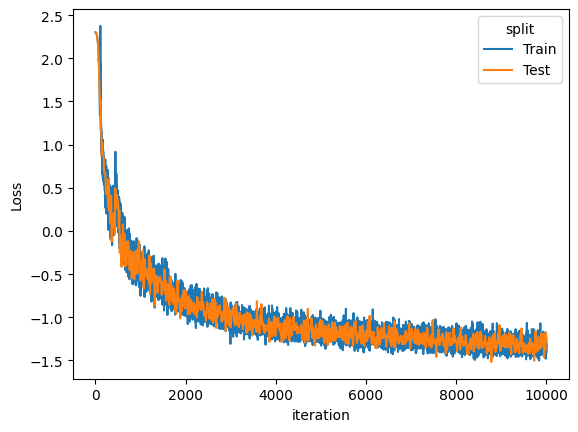

In [14]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{EXP_DIR}/icnn_training_stats.csv')  
# training_stats_melted.to_csv(f'{EXP_DIR}/icnn_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
training_stats = pd.read_csv(f'{EXP_DIR}/icnn_training_stats.csv', index_col=[0])  
training_stats_melted = pd.read_csv(f'{EXP_DIR}/icnn_training_stats_melted.csv', index_col=[0])  



g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")

## Sklearn Training

In [170]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [15]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)

## Metrics Evolution with ICNN Training

In [ ]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{EXP_DIR}/r2_iters_test_results.csv')
# FIRST TIME - END 
r2_iters_test_results = pd.read_csv(f'{EXP_DIR}/r2_iters_test_results.csv', index_col=[0])

## Metrics of the Last ICNN Snapshot

In [18]:
model = model.load_params_from_archive(f'{EXP_DIR}/params.zip', 'step9999.eqx')

In [36]:
# FIRST TIME - BEGIN 
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{EXP_DIR}/icnn_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{EXP_DIR}/icnn_pred_X_test_std.csv')
# FIRST TIME - END 

X_test_imp_df = pd.read_csv(f'{EXP_DIR}/icnn_pred_X_test_imp.csv', index_col=[0])
X_test_std_df = pd.read_csv(f'{EXP_DIR}/icnn_pred_X_test_std.csv', index_col=[0])
X_test_imp = X_test_imp_df.to_numpy()
X_test_std = X_test_std_df.to_numpy()


In [19]:
# FIRST TIME - BEGIN 
# SE = (X_test_imp - obs_val_test) ** 2
# SE = jnp.where(prediction_mask, SE, jnp.nan)
# X_test_var = jnp.where(prediction_mask, X_test_std ** 2, jnp.nan)

# se_data = defaultdict(list)
# for i in range(SE.shape[1]):
#     se_data['SE'].extend(np.array(SE[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['sigma2'].extend(np.array(X_test_var[:, i][prediction_mask[:, i].astype(bool)]).tolist())
#     se_data['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
    
# se_df = pd.DataFrame(se_data)
# se_df.to_csv(f'{EXP_DIR}/icnn_se_stats.csv')
# FIRST TIME - END 

# LATER TIMES
se_df = pd.read_csv(f'{EXP_DIR}/icnn_se_stats.csv', index_col=[0])

In [ ]:
# FIRST TIME - BEGIN 

# features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp.T, prediction_mask.T)
# sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
# r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                       for t in sigma_threshold]
# r2_test_thresholded_df = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
# r2_test_thresholded_df['sigma_threshold'] = sigma_threshold

# r2_test_thresholded_melted_df = pd.melt(r2_test_thresholded_df, value_vars=list(obs_val.columns), id_vars=['sigma_threshold'], value_name='R2')


# icnn_features_stats = defaultdict(list)
# n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)

# for feature, feature_df in se_df.groupby('Feature'):
#     icnn_features_stats['Feature'].append(feature)
#     icnn_features_stats['n_training_measured'].append(n_train_measured[feature2index[feature]])
#     icnn_features_stats['n_training_censored'].append(n_train[feature2index[feature]])
#     icnn_features_stats['n_test_censored'].append(n_test[feature2index[feature]])
#     icnn_features_stats['missingness'].append(missingness[feature2index[feature]].item())
#     icnn_features_stats['R2'].append(features_r2[feature2index[feature]].item())
#     icnn_features_stats['sigma2_se_spearman'].append(spearmanr(feature_df['SE'], feature_df['sigma2']).statistic)
    
# icnn_features_stats_df = pd.DataFrame(icnn_features_stats)


# r2_test_thresholded_df.to_csv(f'{EXP_DIR}/r2_test_thresholded.csv')
# r2_test_thresholded_melted_df.to_csv(f'{EXP_DIR}/r2_test_thresholded_melted.csv')
# icnn_features_stats_df.to_csv(f'{EXP_DIR}/icnn_features_stats.csv')  

# LATER TIMES
r2_test_thresholded_df = pd.read_csv(f'{EXP_DIR}/r2_test_thresholded.csv', index_col=[0])
r2_test_thresholded_melted_df = pd.read_csv(f'{EXP_DIR}/r2_test_thresholded_melted.csv', index_col=[0])
icnn_features_stats_df = pd.read_csv(f'{EXP_DIR}/icnn_features_stats.csv', index_col=[0])


In [ ]:
g = sns.stripplot(data=r2_test_results, x="sigma_threshold", y="R2", hue="variable")


In [222]:
spearman_se_sigma_all = spearmanr(se_df['SE'], se_df['sigma2']).statistic
pearson_se_sigma_all = pearsonr(se_df['SE'], se_df['sigma2']).statistic
r2_all = ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp, prediction_mask)
icnn_global_stats = pd.DataFrame({r'$r_\text{Pearson}(SE, \sigma^2)$': [pearson_se_sigma_all],
                                  r'$r_\text{Searson}(SE, \sigma^2)$': [spearman_se_sigma_all],
                                  r'$R^2(z, \mu)$': [r2_all]})
icnn_global_stats.to_csv(f'{EXP_DIR}/icnn_global_stats.csv')  
icnn_global_stats

## Metrics of Sklearn Models

In [171]:
sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 

In [223]:
sklearn_performance_data = defaultdict(list)
sklearn_performance_per_feature_data = defaultdict(list)
    
for sklearn_imputer_name, sklearn_imputed_X_ in sklearn_imputed_X.items():
    r2 = ProbICNNImputerTrainer.r_squared(obs_val_test, sklearn_imputed_X_, prediction_mask)
    features_r2 = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, sklearn_imputed_X_.T, prediction_mask.T)

    sklearn_performance_data['sklearn_imputer'].append(sklearn_imputer_name)
    sklearn_performance_data['R2'].append(r2.item())

    sklearn_performance_per_feature_data['R2'].extend(features_r2.tolist())
    sklearn_performance_per_feature_data['sklearn_imputer'].extend([sklearn_imputer_name] * len(obs_val.columns))
    sklearn_performance_per_feature_data['feature'].extend(obs_val.columns.tolist())
    sklearn_performance_per_feature_data['missingness'].extend(missingness.tolist())

sklearn_performance_df = pd.DataFrame(sklearn_performance_data)
sklearn_performance_per_feature_df = pd.DataFrame(sklearn_performance_per_feature_data)


In [224]:
sklearn_performance_per_feature_df.to_csv(f'{EXP_DIR}/sklearn_features_stats.csv')
sklearn_performance_df.to_csv(f'{EXP_DIR}/sklearn_stats.csv')

In [225]:
sklearn_performance_df

In [210]:
sklearn_performance_per_feature_df[(sklearn_performance_per_feature_df.missingness < 0.8)].sort_values(['sklearn_imputer', 'R2'])

In [212]:
feature_corrs_df[(feature_corrs_df.missingness < 0.8)].sort_values('R2')

In [197]:
r2_test_results = r2_test_results[r2_test_results.R2 >= 0.1]
r2_test_results